# 케글

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns


## 데이터 확인

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/home/aiffel-dj26/aiffel/kaggle_kakr_housing/data/train.csv
/home/aiffel-dj26/aiffel/kaggle_kakr_housing/data/test.csv


In [3]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [4]:
print('우편번호 같은 갯수',sum(data['zipcode'].duplicated()))
print('위도 같은 갯수',sum(data['lat'].duplicated()))
print('경도 같은 갯수',sum(data['long'].duplicated()))
print('id 같은 갯수',sum(data['id'].duplicated()))


우편번호 같은 갯수 14965
위도 같은 갯수 10343
경도 같은 갯수 14319
id 같은 갯수 0


In [5]:
y = data['price']
del data['price']

print(data.columns)


Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

21503


In [7]:
data.head(6)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
5,5,20150403T000000,3,2.50,3560,9796,1.0,0,0,3,8,1860,1700,1965,0,98007,47.6007,-122.145,2210,8925


## 데이터 분석 아이디어
### 1.주거및 대지면적이 두가지 버전이 있다. 15년도와 원본인데 캐글상에서는 재건축일 때 변화할 수 있다고 하지만 데이터는 다르게 재건축 여부와 상관없이 변해있는 것으로 보인다.  
#### 가정
- 15년도에 측량법이 수정되어 다르게 나타난다  ---> 기본 버전을 한번 버려본다 
- 재건축연도의 데이터가 이상하다.  ---> 위의 가정에서 결과가 별로면 한번 시도 

### 2.재건축연도,지하실크기에 0이 찍혀 데이터의 분석이 어려워 보인다.  
재건축연도에서 건축연도를 빼서 격차를 줄어보자. 지상 지하의 비율로 변환해보자.



### 추가적인 생각 
집을 계약한 날과 재건축한 날과의 차이를 데이터에 추가해보면 살 당시의 집의 나이를 알수 있지 않을까

In [8]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))
data['date'] = data['date'].apply(lambda x : x[:6]).astype(int)
data['sqft_above'] = round((data['sqft_above']/data['sqft_living']),4)
data['sqft_basement'] = round((data['sqft_basement']/data['sqft_living']),4)
data['yr_renovated'] = np.where(data['yr_renovated']>0,data['yr_renovated'],data['yr_built'])
data['new'] = data['date']//100 - data['yr_renovated']
# data['yr_renovated'] = data['yr_renovated'] - data['yr_built']

In [9]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,new
0,0,201410,3,1.00,1180,5650,1.0,0,0,3,...,1.0,0.0,1955,0,98178,47.5112,-122.257,1340,5650,59
1,1,201502,2,1.00,770,10000,1.0,0,0,3,...,1.0,0.0,1933,0,98028,47.7379,-122.233,2720,8062,82
2,2,201502,3,2.00,1680,8080,1.0,0,0,3,...,1.0,0.0,1987,0,98074,47.6168,-122.045,1800,7503,28
3,3,201406,3,2.25,1715,6819,2.0,0,0,3,...,1.0,0.0,1995,0,98003,47.3097,-122.327,2238,6819,19
4,4,201501,3,1.50,1060,9711,1.0,0,0,3,...,1.0,0.0,1963,0,98198,47.4095,-122.315,1650,9711,52


In [10]:
data.tail()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,new
6463,21498,201406,3,1.75,1500,11968,1.0,0,0,3,...,1.0000,0.0000,2014,0,98010,47.3095,-122.002,1320,11303,0
6464,21499,201501,3,2.00,1490,1126,3.0,0,0,3,...,1.0000,0.0000,2014,0,98144,47.5699,-122.288,1400,1230,1
6465,21500,201502,3,2.50,1310,1294,2.0,0,0,3,...,0.9008,0.0992,2008,0,98116,47.5773,-122.409,1330,1265,7
6466,21501,201406,2,0.75,1020,1350,2.0,0,0,3,...,1.0000,0.0000,2009,0,98144,47.5944,-122.299,1020,2007,5
6467,21502,201501,3,2.50,1600,2388,2.0,0,0,3,...,1.0000,0.0000,2004,0,98027,47.5345,-122.069,1410,1287,11


## 결측치 확인

In [11]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0
new : 0


In [12]:
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'new'],
      dtype='object')


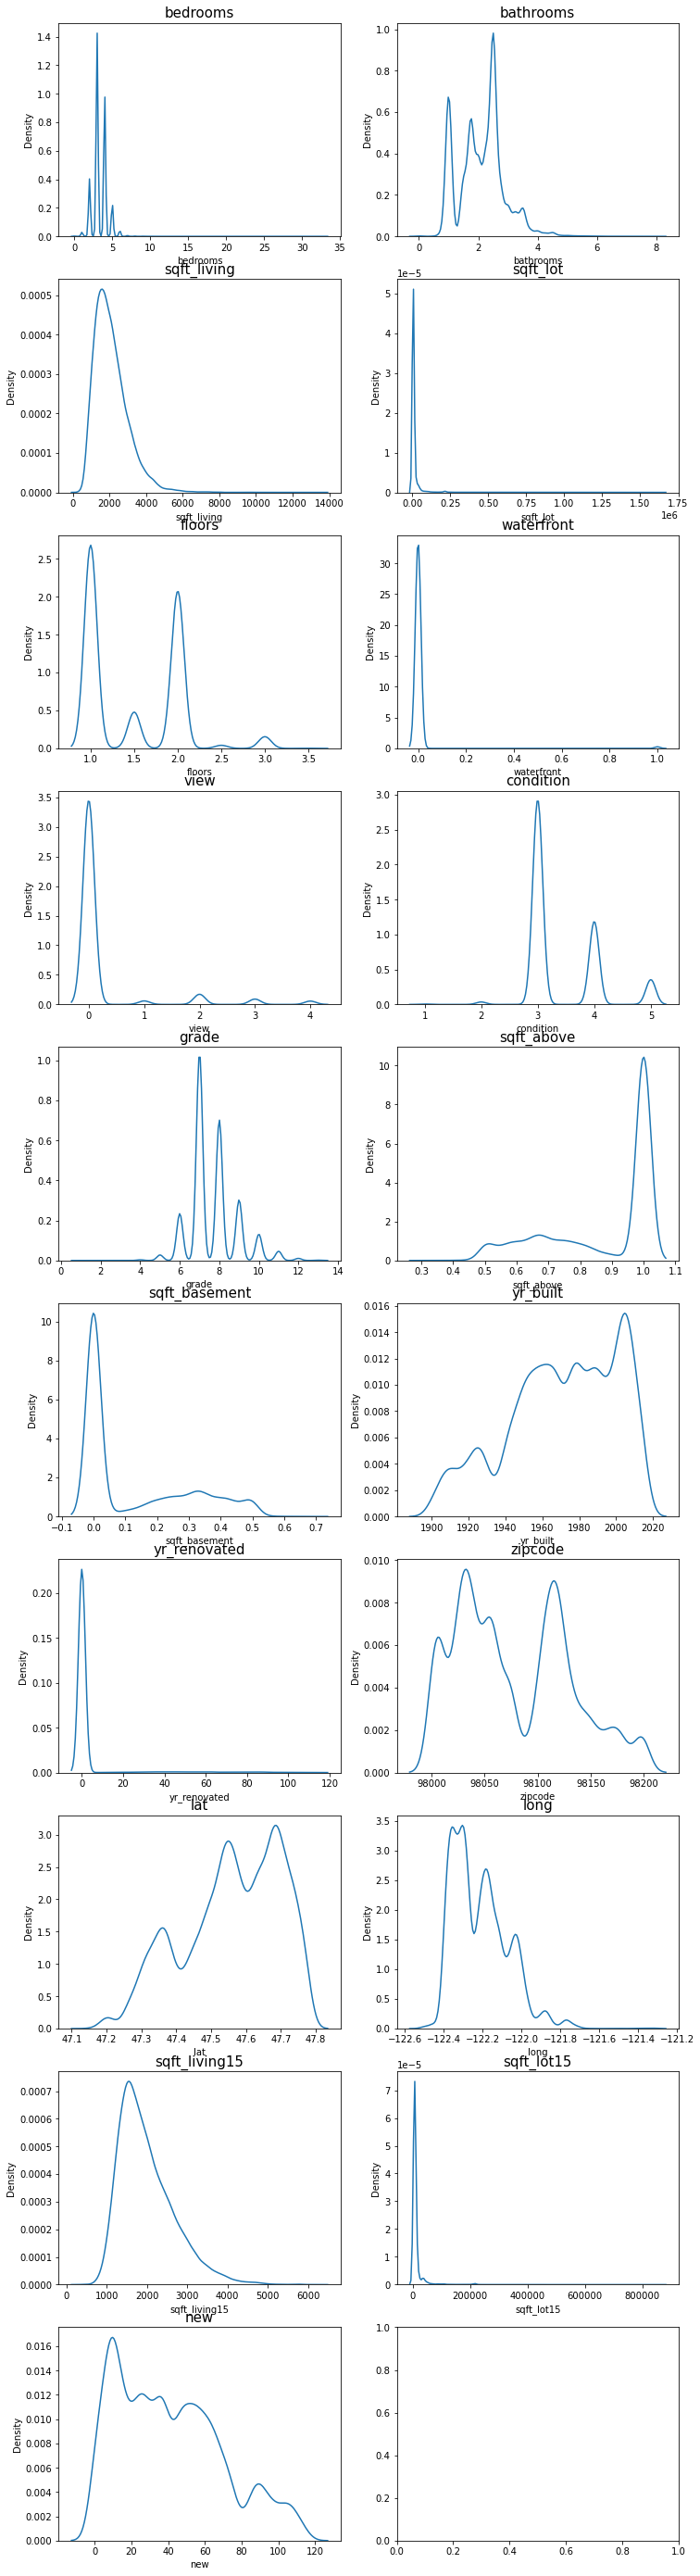

In [13]:
fig, ax = plt.subplots(10, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 20 :
            break

In [14]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

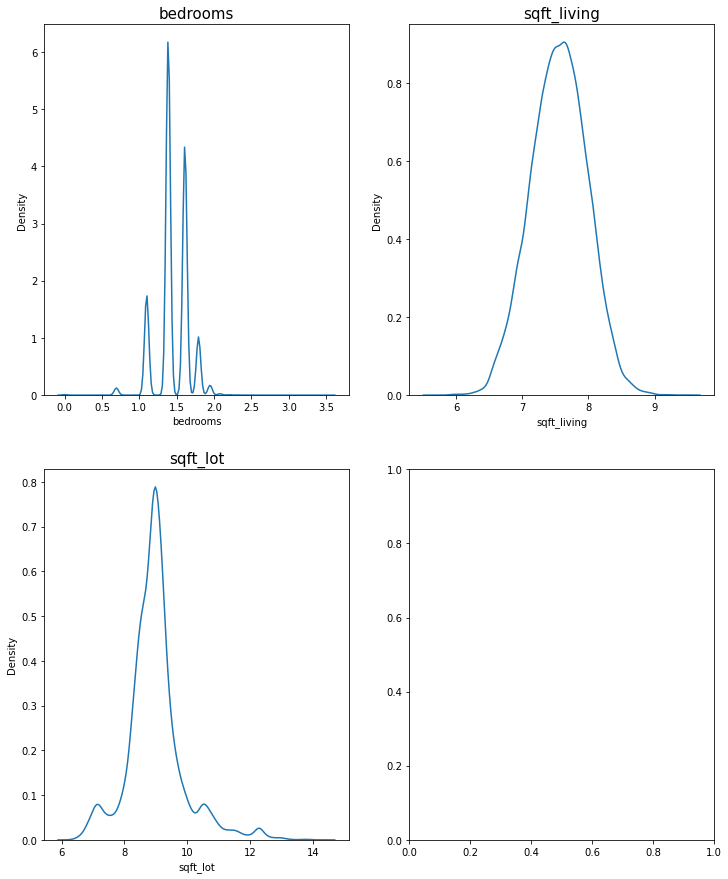

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(12, 15))

count = 0
for row in range(2):
    for col in range(2):
        if count == 3:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

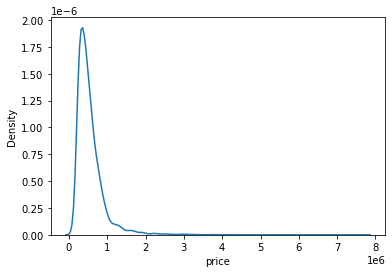

In [16]:
sns.kdeplot(y)
plt.show()

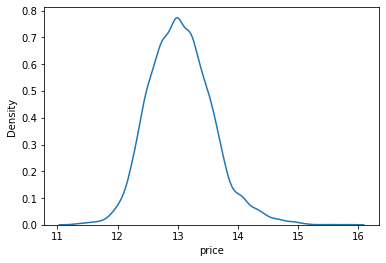

In [17]:
y = np.log1p(y)

sns.kdeplot(y)
plt.show()

In [27]:
sub = data.iloc[train_len:]
x = data.iloc[:train_len]

print(x.shape)
print(sub.shape)

(15035, 20)
(6468, 20)


In [19]:
print(len(x.isnull()))
for c in x.columns:
    print('{} : {}'.format(c, len(x.loc[pd.isnull(x[c]), c].values)))


15035
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0
new : 0


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=2020        

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [21]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


In [22]:
def get_scores(models, train, y):
    
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df    

get_scores(models, x, y)

,RMSE
GradientBoostingRegressor,128273.749474
RandomForestRegressor,125299.004297
LGBMRegressor,115639.689550
XGBRegressor,112387.532034


In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [24]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [25]:
a =[]
for i in models:
    a.append(my_GridSearch(i,x,y,param_grid,verbose= 2,n_jobs=5))
    

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:   14.0s finished
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:   19.2s finished
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:   14.0s finished
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    8.9s finished


In [26]:
a

[   max_depth  n_estimators     score     RMSLE
 3         10           100 -0.029298  0.171168
 2         10            50 -0.029787  0.172590
 1          1           100 -0.055051  0.234630
 0          1            50 -0.073256  0.270658,
    max_depth  n_estimators     score     RMSLE
 2         10            50 -0.030593  0.174908
 3         10           100 -0.030934  0.175880
 1          1           100 -0.043011  0.207391
 0          1            50 -0.048746  0.220786,
    max_depth  n_estimators     score     RMSLE
 3         10           100 -0.027120  0.164682
 2         10            50 -0.029258  0.171050
 1          1           100 -0.055044  0.234614
 0          1            50 -0.073398  0.270920,
    max_depth  n_estimators     score     RMSLE
 3         10           100 -0.035204  0.187628
 2         10            50 -0.035407  0.188168
 1          1           100 -0.179128  0.423235
 0          1            50 -0.179746  0.423965]

In [28]:
gboost = GradientBoostingRegressor(max_depth = 10,n_estimators = 100,random_state=random_state)
xgboost = XGBRegressor(max_depth = 10,n_estimators = 50,random_state=random_state)
lightgbm = LGBMRegressor(max_depth = 10,n_estimators = 100,random_state=random_state)
rdforest = RandomForestRegressor(max_depth = 10,n_estimators = 100,random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [29]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [30]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m.fit(x.values, y)
    
    predictions = np.column_stack([
        m.predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)


In [31]:

y_pred = np.expm1(AveragingBlending(models, x, y, sub))
print(len(y_pred))
y_pred

6468


array([ 494689.36197282,  477767.32606062, 1386178.83932522, ...,
        468226.12377794,  328487.33704963,  443804.3563902 ])

In [32]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,4.946894e+05
1,15036,4.777673e+05
2,15037,1.386179e+06
3,15038,2.994196e+05
4,15039,3.258433e+05


In [33]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/home/aiffel-dj26/aiffel/kaggle_kakr_housing/data/submission.csv


# 9-9